In [14]:
!pip install minihack gym==0.23.1
!pip install stable-baselines3[extra]
!apt-get install -y libgl1-mesa-glx
!pip install cmake

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [157]:
import gymnasium as gym
import minihack
from minihack.envs.room import MiniHackRoom5x5
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

In [182]:
from minihack import MiniHackNavigation
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from nle import nethack

MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.MiscDirection.WAIT,
    nethack.Command.PICKUP,
    nethack.Command.OPEN,
    nethack.Command.APPLY,
    nethack.MiscDirection.DOWN
)

def make_env():
    return gym.make("MiniHack-KeyRoom-Fixed-S5-v0", actions=NAVIGATE_ACTIONS, render_mode="ansi")

env = DummyVecEnv([make_env])

In [183]:
model = PPO("MultiInputPolicy", env, verbose=1)

model.learn(total_timesteps=10_000)

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 380  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 339         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016377037 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_variance   | -5.87       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0286      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 0.00852     |
-----------------------------------------
----------------

In [160]:
rewardsArr = []

obs = env.reset()
for _ in range(10000):
    action, _ = model.predict(obs)
    obs, rewards, dones, infos = env.step(action)
    rewardsArr.append(rewards)
    if (rewards == 1):
      break
    frame = env.get_attr('render')[0]()
    print(frame)

                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                          |                                    
                                    ---- .|                                    
                                    |.@.

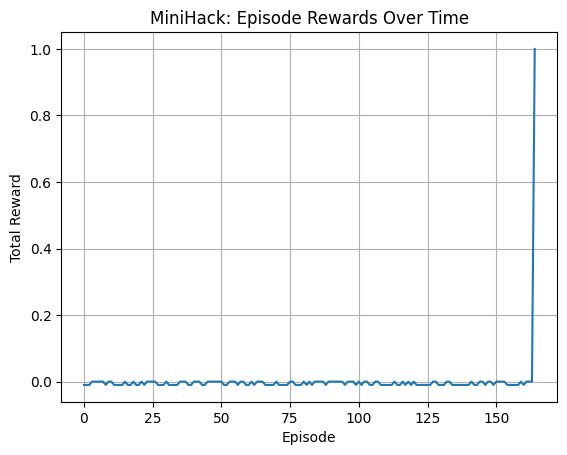

In [161]:
import matplotlib.pyplot as plt

plt.plot(rewardsArr)
plt.title("MiniHack: Episode Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [197]:
import numpy as np

class NetHackAgent:
    def __init__(self):
        self.step_count = 0
        self.key_pos = None
        self.agent_pos = None
        self.goal_pos = None
        self.door_pos = None
        self.key_exists = False
        self.has_key = False
        self.door_open = False

    def up(self):
        return 0
    def left(self):
        return 3
    def right(self):
        return 1
    def down(self):
        return 2
    def wait(self):
        return 8
    def pickup(self):
        return 9
    def open(self):
        return 10
    def apply(self):
        return 11

    def act(self, obs):
        if self.step_count < 4:
            return self.down()
        elif self.step_count < 8:
            return self.right()
        if self.key_pos != None:
            if self.key_pos[0] > self.agent_pos[0]:
                return self.right()
            elif self.key_pos[0] < self.agent_pos[0]:
                return self.left()
            if self.key_pos[0] == self.agent_pos[0]:
                if self.key_pos[1] < self.agent_pos[1]:
                    return self.up()
                elif self.key_pos[1] > self.agent_pos[1]:
                    return self.down()
        if self.key_pos == None:
          if self.key_exists == True:
              self.key_exists = False
              self.has_key = True
              return self.pickup()
        if self.has_key == True:
          if self.door_pos != None:
            if self.door_pos[0] > self.agent_pos[0] - 1:
                return self.right()
            elif self.door_pos[0] < self.agent_pos[0] - 1:
                return self.left()
            if self.door_pos[0] == self.agent_pos[0] - 1:
                if self.door_pos[1] < self.agent_pos[1]:
                    return self.up()
                if self.door_pos[1] > self.agent_pos[1]:
                    return self.down()
                if self.door_pos[1] == self.agent_pos[1]:
                    self.has_key = False
                    self.door_open = True
                    return self.apply()
        if self.door_open == True:
          if self.goal_pos != None:
            if self.goal_pos[0] > self.agent_pos[0]:
                return self.right()
            elif self.goal_pos[0] < self.agent_pos[0]:
                return self.left()
            if self.goal_pos[0] == self.agent_pos[0]:
                if self.goal_pos[1] < self.agent_pos[1]:
                    return self.up()
                if self.goal_pos[1] > self.agent_pos[1]:
                    return self.down()
        return self.wait()


    def find_char_pos(chars, target=ord('(')):
        chars = chars[0]
        ys, xs = np.where(chars == target)
        if len(xs) > 0:
          return (xs[0], ys[0])
        return None

    def increment_step_count(self):
        self.step_count += 1

    def update_position(self):
        self.agent_pos = NetHackAgent.find_char_pos(obs["chars"], target=ord('@'))
        self.key_pos = NetHackAgent.find_char_pos(obs["chars"], target=ord('('))
        self.goal_pos = NetHackAgent.find_char_pos(obs["chars"], target=ord('>'))
        self.door_pos = NetHackAgent.find_char_pos(obs["chars"], target=ord('+'))
        print("Agent position:", self.agent_pos)
        print("Key position:", self.key_pos)
        print("Goal position:", self.goal_pos)
        print("Door position:", self.door_pos)
        if self.key_pos != None:
          self.key_exists = True
          print("Key reachable!")
        if self.goal_pos != None:
          print("Goal reachable!")

In [202]:
agent = NetHackAgent()
obs = env.reset()
total_rewards = 0
symbolic_rewards = []

for _ in range(50):
    NetHackAgent.update_position(agent)
    action = [agent.act(o) for o in obs]
    NetHackAgent.increment_step_count(agent)
    obs, rewards, dones, infos = env.step(action)
    total_rewards += rewards[0]
    symbolic_rewards.append(total_rewards)
    frame = env.get_attr('render')[0]()
    print(frame)
    if dones[0]:
        break

Agent position: (np.int64(38), np.int64(12))
Key position: None
Goal position: None
Door position: None
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                                         --                                    
                                         .|                                    
                                         (|                                    
                

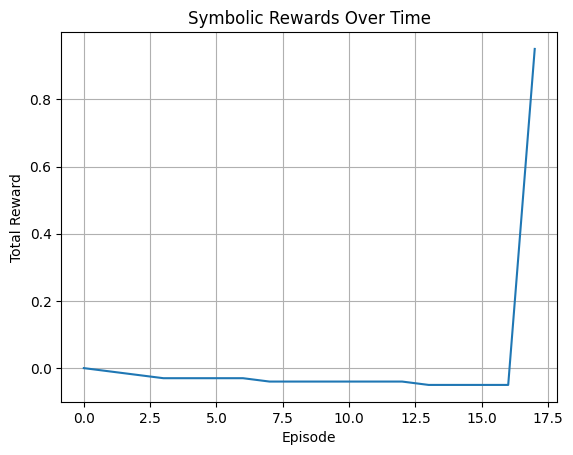

In [203]:
import matplotlib.pyplot as plt

plt.plot(symbolic_rewards)
plt.title("Symbolic Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()